In [1]:
# !pip install torch torchvision

# !pip install -U transformers
# !pip install -U albumentations
# !pip install -U opencv-python
# !pip install -U scikit-learn
# !pip install -U Pillow
# !pip install -U tqdm
# !pip install -U pandas
# !pip install -U torchsummary
# !pip install timm
# !pip install ipywidgets

In [2]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from tqdm.notebook import tqdm
from itertools import product

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from torchsummary import summary

import timm

In [4]:
import torch
from torch.optim.optimizer import Optimizer


class Lion(Optimizer):
  r"""Implements Lion algorithm."""

  def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
    """Initialize the hyperparameters.
    Args:
      params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
      lr (float, optional): learning rate (default: 1e-4)
      betas (Tuple[float, float], optional): coefficients used for computing
        running averages of gradient and its square (default: (0.9, 0.99))
      weight_decay (float, optional): weight decay coefficient (default: 0)
    """

    if not 0.0 <= lr:
      raise ValueError('Invalid learning rate: {}'.format(lr))
    if not 0.0 <= betas[0] < 1.0:
      raise ValueError('Invalid beta parameter at index 0: {}'.format(betas[0]))
    if not 0.0 <= betas[1] < 1.0:
      raise ValueError('Invalid beta parameter at index 1: {}'.format(betas[1]))
    defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
    super().__init__(params, defaults)

  @torch.no_grad()
  def step(self, closure=None):
    """Performs a single optimization step.
    Args:
      closure (callable, optional): A closure that reevaluates the model
        and returns the loss.
    Returns:
      the loss.
    """
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue

        # Perform stepweight decay
        p.data.mul_(1 - group['lr'] * group['weight_decay'])

        grad = p.grad
        state = self.state[p]
        # State initialization
        if len(state) == 0:
          # Exponential moving average of gradient values
          state['exp_avg'] = torch.zeros_like(p)

        exp_avg = state['exp_avg']
        beta1, beta2 = group['betas']

        # Weight update
        update = exp_avg * beta1 + grad * (1 - beta1)
        p.add_(torch.sign(update), alpha=-group['lr'])
        # Decay the momentum running average coefficient
        exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)

    return loss

In [5]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# Подготовка данных для обучения

In [6]:
root_dir = 'dataset'
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
data = pd.DataFrame([
    {'image_path': os.path.join(directory, filename), 'label': os.path.basename(directory)}
    for directory, _, filenames in os.walk(root_dir)
    for filename in filenames
    if os.path.basename(directory).isdigit()
])

In [8]:
label2id = {value: i for i, value in enumerate(data['label'].unique())}
data['label_id'] = data['label'].map(label2id)

In [9]:
data['label_id'].value_counts()

label_id
0     600
1     600
2     600
3     600
4     600
5     600
6     600
7     600
8     600
9     600
10    600
11    600
12    600
13    600
14    600
Name: count, dtype: int64

In [10]:
train, val, _, _ = train_test_split(data, data['label_id'], test_size=0.1)

In [11]:
class ProductDataset(Dataset):

    def __init__(self, meta, transform=None):
        self.meta = meta
        self.transform = transform
        self.preprocessing = A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.meta['image_path'].iloc[idx]
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image = np.asarray(image))['image']
            image = Image.fromarray(image)

        image = self.preprocessing(image=np.asarray(image))['image']
            
        cls = self.meta['label_id'].iloc[idx]

        return image, cls

In [12]:
train_transform = A.Compose([
        # A.GaussNoise(p=0.2),
        # A.OneOf([
        #     A.MotionBlur(p=.2),
        #     A.MedianBlur(blur_limit=3, p=0.1),
        #     A.Blur(blur_limit=3, p=0.1),
        # ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.2, rotate_limit=30, p=0.75),
        # A.OneOf([
        #     A.OpticalDistortion(p=0.3),
        #     A.GridDistortion(p=.1),
        #     A.PiecewiseAffine(p=0.3),
        # ], p=0.2),
        # A.OneOf([
        #     A.CLAHE(clip_limit=2),
        #     A.Sharpen(),
        #     A.Emboss(),
        #     A.RandomBrightnessContrast(),            
        # ], p=0.3),
        # A.HueSaturationValue(p=0.3),
])

transform = None

/home/vladimir/.virtualenvs/topic2/lib/python3.10/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [13]:
img_name = train['image_path'].iloc[0]
img_name
image = Image.open(img_name).convert('RGB')
image = np.asarray(image)
image.shape
image = train_transform(image = np.asarray(image))['image']
image = Image.fromarray(image)
# image = self.preprocessing(image=image)['image']

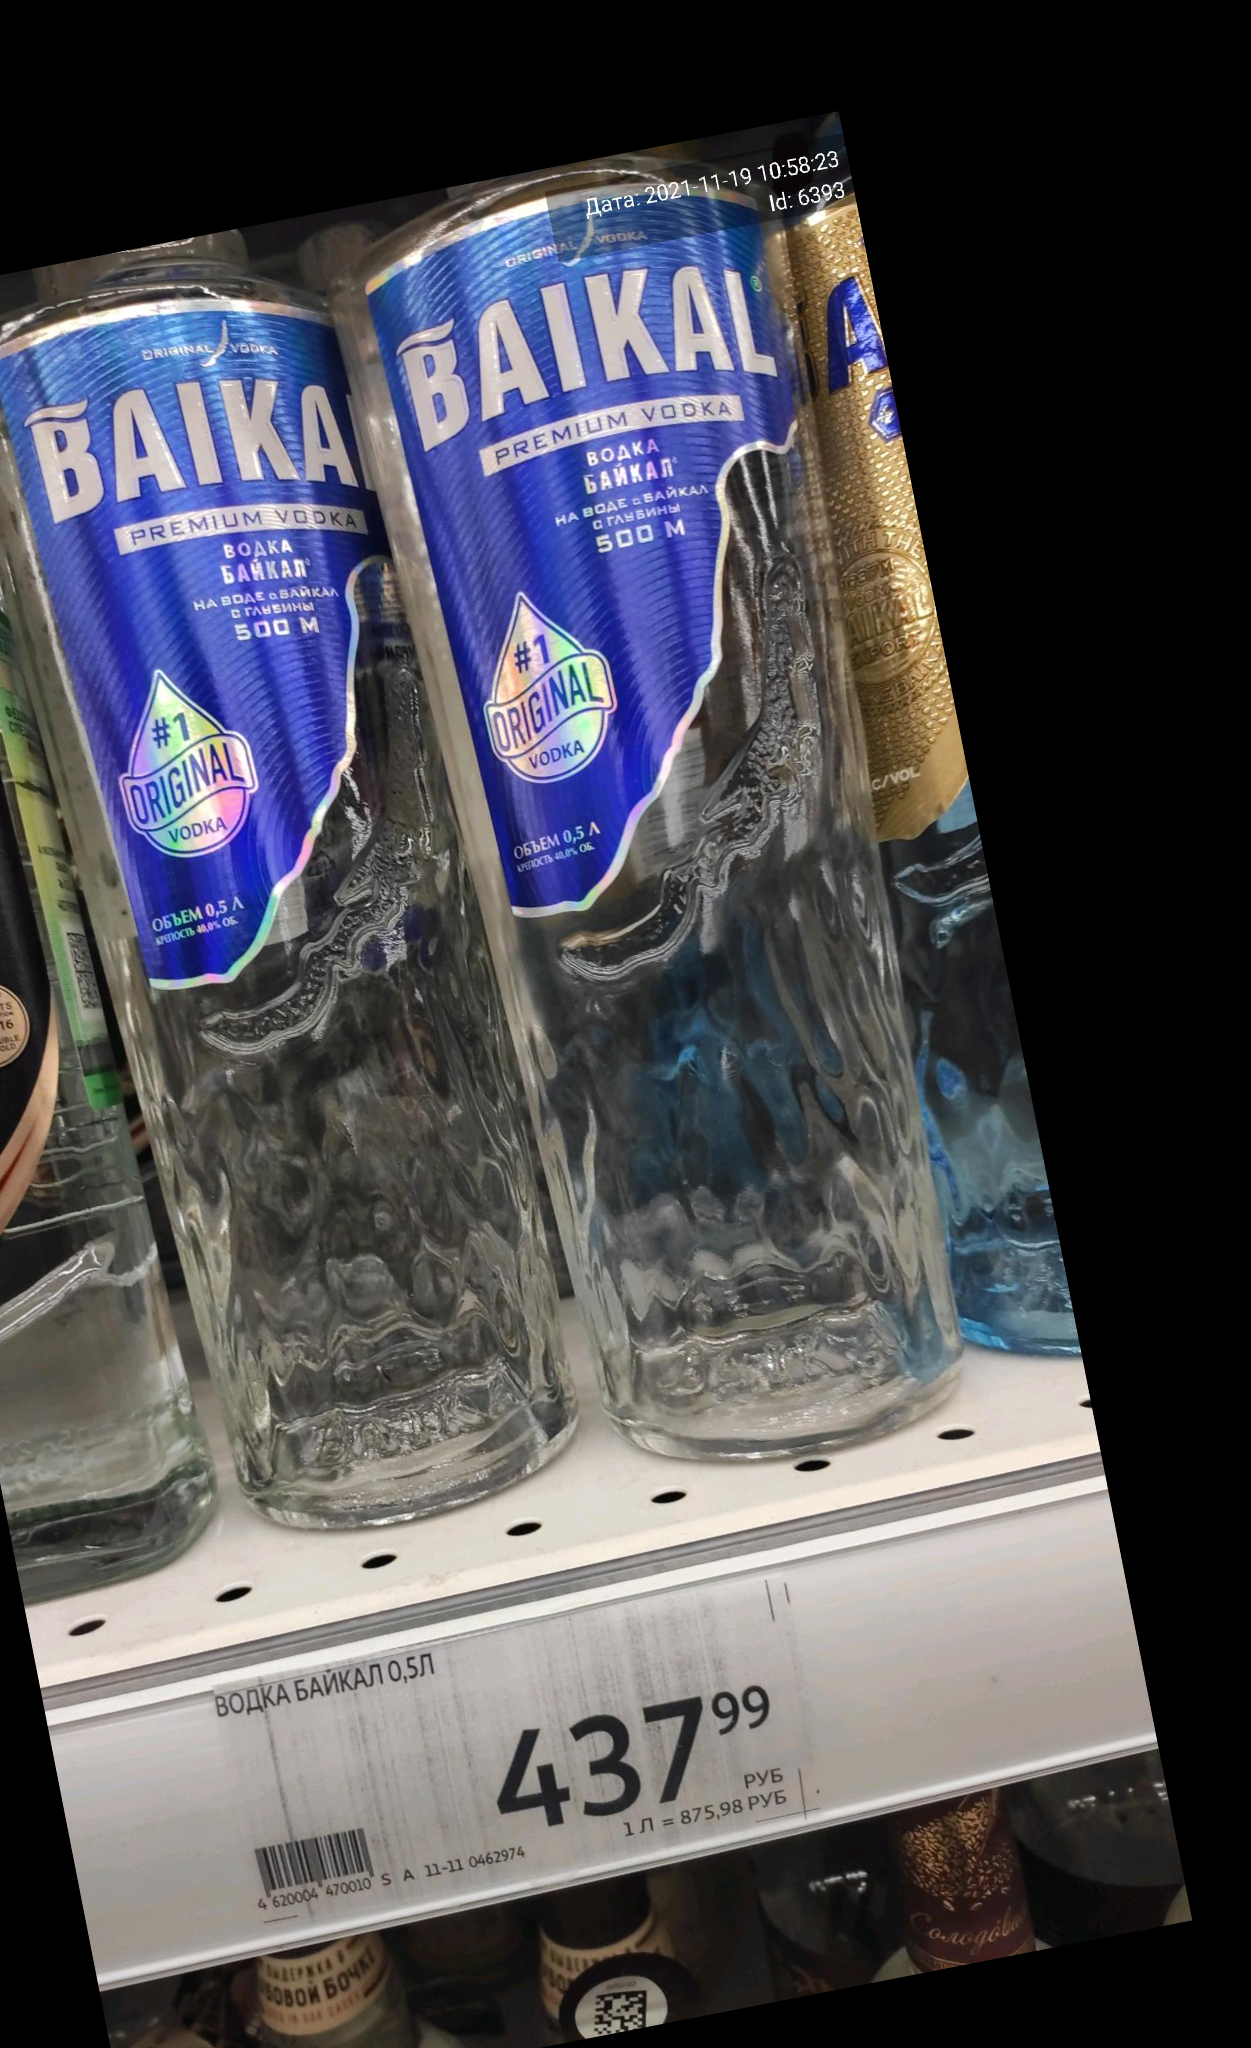

In [14]:
image

In [15]:
train_dataset = ProductDataset(meta=train, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True, drop_last=True)

val_dataset = ProductDataset(meta=val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

# Создание модели и обучение

In [16]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [17]:
model = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=0)
# model.global_pool = nn.Flatten()
model.global_pool = nn.Sequential(
    GeM(),
    nn.Flatten()
)
model.fc = nn.Linear(2048, len(label2id))
# model.fc = nn.Linear(75264, len(label2id))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [18]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [19]:
EPOCHS = 5
lr = 1e-3

optimizer = optim.AdamW(model.parameters(), lr)

criterion = nn.CrossEntropyLoss()

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

https://github.com/ufoym/imbalanced-dataset-sampler

https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling

In [20]:
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

In [21]:
for epoch in range(EPOCHS):
    
    if epoch == 2:
    
        for param in model.parameters():
            param.requires_grad = True
    
    model.train()
        
    train_loss = []
    train_predictions = []
    train_targets = []
    for batch, targets in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
        optimizer.zero_grad()
        
        batch = batch.to(device)
        targets = targets.to(device)
        
        predictions = model(batch)
        
        loss = criterion(predictions, targets)
        
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
        train_predictions.extend(predictions.cpu().detach().numpy().argmax(axis=1))
        train_targets.extend(targets.cpu().detach().numpy())
        
    print('Training loss:', np.mean(train_loss))
    print('Train f1:', f1_score(train_targets, train_predictions, average='weighted'))
    
    model.eval()
        
    val_predictions = []
    val_targets = []
    for batch, targets in tqdm(val_dataloader, desc=f"Epoch: {epoch}"):
        
        with torch.no_grad():
        
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)
            

            val_predictions.extend(predictions.cpu().numpy().argmax(axis=1))
            val_targets.extend(targets.cpu().numpy())
        
    print('Val f1:', f1_score(val_targets, val_predictions, average='weighted'))

Epoch: 0:   0%|          | 0/253 [00:00<?, ?it/s]

Training loss: 1.2570050461254572
Train f1: 0.661837619949184


Epoch: 0:   0%|          | 0/29 [00:00<?, ?it/s]

Val f1: 0.7785113878944289


Epoch: 1:   0%|          | 0/253 [00:00<?, ?it/s]

Training loss: 0.6257651323386332
Train f1: 0.8140955479890255


Epoch: 1:   0%|          | 0/29 [00:00<?, ?it/s]

Val f1: 0.8242348149533819


Epoch: 2:   0%|          | 0/253 [00:00<?, ?it/s]

Training loss: 0.2441310697481802
Train f1: 0.902733671533869


Epoch: 2:   0%|          | 0/29 [00:00<?, ?it/s]

Val f1: 0.9056277054237464


Epoch: 3:   0%|          | 0/253 [00:00<?, ?it/s]

Training loss: 0.13556357702100466
Train f1: 0.9467196634048641


Epoch: 3:   0%|          | 0/29 [00:00<?, ?it/s]

Val f1: 0.903284436564349


Epoch: 4:   0%|          | 0/253 [00:00<?, ?it/s]

Training loss: 0.10272223481415171
Train f1: 0.9609929149467428


Epoch: 4:   0%|          | 0/29 [00:00<?, ?it/s]

Val f1: 0.9363674383412472


In [22]:
predictions.shape

torch.Size([4, 15])

# Test Time Augmentation 

In [23]:
val_dataset = ProductDataset(meta=val, transform=train_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

In [24]:
model.eval()

all_val_predictions = np.zeros((val.shape[0], 15))

for _ in range(10):
    val_predictions = []
    val_targets = []
    for batch, targets in tqdm(val_dataloader):

        with torch.no_grad():

            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)


            val_predictions.extend(predictions.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())
    val_predictions = np.array(val_predictions)
    all_val_predictions += val_predictions

print('Val f1:', f1_score(val_targets, all_val_predictions.argmax(axis=1), average='weighted'))

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Val f1: 0.9307413043662031
